In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import keras
import random
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 10


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

  
  



def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
     
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3),
#                       activation='elu',
#                       padding='same',
#                       input_shape=input_shape))
    
#     model.add(Conv2D(64, (3, 3),
#                       activation='elu',
#                       padding='same',
#                       input_shape=input_shape))
    
#     model.add(Conv2D(64, (3, 3),
#                       activation='elu',
#                       padding='same',
#                       input_shape=input_shape))
    
#     model.add(Conv2D(64, (3, 3),
#                       activation='elu',
#                       padding='same',
#                       input_shape=input_shape))
    
#     model.add(Flatten())
    
#     model.add(Dense(128, activation ='elu'))
      
    input_img = Input(shape = (28, 28, 1))
    tower_1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_1 = Conv2D(64, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(64, (1,1), padding='same', activation='relu')(input_img)
    tower_2 = Conv2D(64, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
    tower_3 = Conv2D(64, (1,1), padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
    output = Flatten()(output)
    out    = Dense(10, activation='softmax')(output)

    
    
    
    
    model = Model(inputs = input_img, outputs = out)
#     input = Input(shape=input_shape)
#     x = Flatten()(input)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
#     x = Dropout(0.1)(x)
#     x = Dense(128, activation='elu')(x)
    return model

  
  


  

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.astype('float32')
x_test = x_test.reshape(10000,28,28,1)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 108400 samples, validate on 17820 samples
Epoch 1/10
108400/108400 [==============================] - 42s 386us/step - loss: 0.0569 - accuracy: 0.9333 - val_loss: 0.0319 - val_accuracy: 0.9672
Epoch 2/10
108400/108400 [==============================] - 39s 355us/step - loss: 0.0236 - accuracy: 0.9759 - val_loss: 0.0256 - val_accuracy: 0.9763
Epoch 3/10
108400/108400 [==============================] - 39s 357us/step - loss: 0.0159 - accuracy: 0.9845 - val_loss: 0.0255 - val_accuracy: 0.9754
Epoch 4/10
108400/108400 [==============================] - 39s 359us/step - loss: 0.0122 - accuracy: 0.9900 - val_loss: 0.0256 - val_accuracy: 0.9753
Epoch 5/10
108400/108400 [==============================] - 39s 360us/step - loss: 0.0098 - accuracy: 0.9930 - val_loss: 0.0261 - val_accuracy: 0.9744
Epoch 6/10
108400/108400 [==============================] - 39s 360us/step - loss: 0.0083 - a

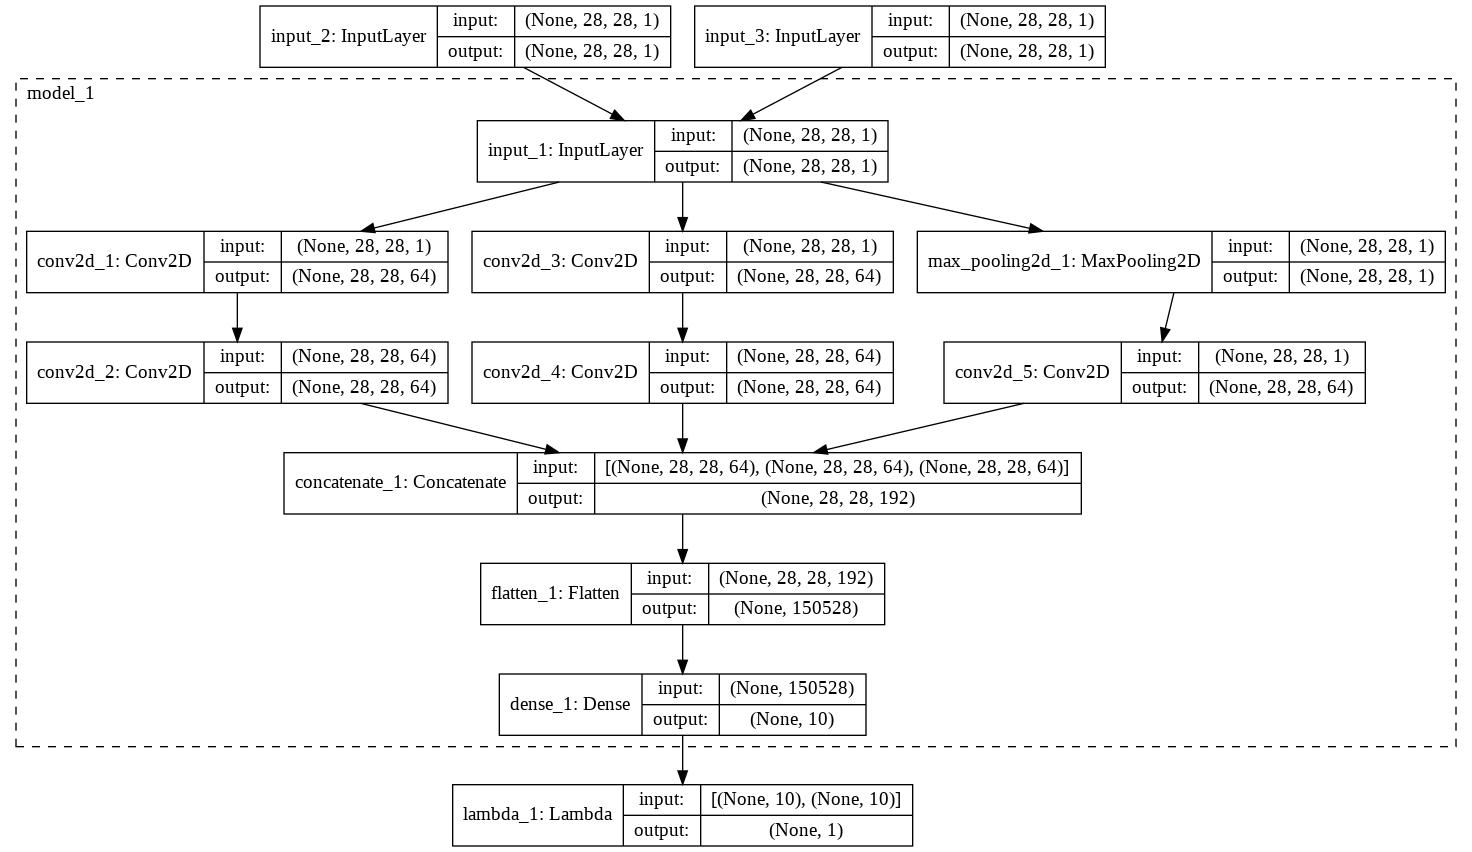

In [0]:


from keras.utils.vis_utils import plot_model

plot_model(model, to_file='accurate.png',show_shapes=True, show_layer_names=True,expand_nested=True)

In [3]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 10)           1645066     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]              

In [2]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

NameError: ignored